In [2]:
import pandas as pd
from database.BuildingRepository import BuildingRepository
from pandas.api.types import is_numeric_dtype
from datetime import datetime, timedelta

building_repo = BuildingRepository()
df = pd.DataFrame(building_repo.get_power_historic(datetime.now()-timedelta(days=30)))
df = df.drop("_id", axis=1)
df['datetime'] = pd.to_datetime(df['datetime'])

df.set_index("datetime", inplace=True)
df = df.resample('15T').mean()
df["datetime"] = df.index

df['totalpower'] = pd.to_numeric(df['totalpower'], errors='coerce')
df['Month'] = df['datetime'].dt.month
df['Day'] = df['datetime'].dt.day
df['Hour'] = df['datetime'].dt.hour
df['Weekday'] = df['datetime'].dt.weekday

df.rename(columns={'totalpower': 'Consumption'}, inplace=True)
df.drop(['datetime', 'totalgeneration'], axis=1, inplace=True)

df = df.dropna()
df['Consumption-1'] = df['Consumption'].shift(1)
df.loc[df['Day'] != df['Day'].shift(1), 'Consumption-1'] = 0
df['Consumption-2'] = df['Consumption'].shift(2)
df.loc[df['Day'] != df['Day'].shift(2), 'Consumption-2'] = 0
#df = df[['Month', 'Day', 'Hour', 'Consumption-1', 'Consumption-2', 'Consumption']]
df = df[['Month', 'Day', 'Hour', 'Weekday', 'Consumption-1', 'Consumption-2', 'Consumption']]
df

,Month,Day,Hour,Weekday,Consumption-1,Consumption-2,Consumption
datetime,,,,,,,
2023-10-15 16:45:00,10,15,16,6,0.000000,0.000000,1325.934579
2023-10-15 17:00:00,10,15,17,6,1325.934579,0.000000,1349.883333
2023-10-15 17:15:00,10,15,17,6,1349.883333,1325.934579,1357.944444
2023-10-15 17:30:00,10,15,17,6,1357.944444,1349.883333,1351.702778
2023-10-15 17:45:00,10,15,17,6,1351.702778,1357.944444,1353.188889
...,...,...,...,...,...,...,...
2023-11-14 15:45:00,11,14,15,1,2984.654441,3126.559991,2979.488881
2023-11-14 16:00:00,11,14,16,1,2979.488881,2984.654441,2941.008447
2023-11-14 16:15:00,11,14,16,1,2941.008447,2979.488881,2838.018886


In [3]:
from sklearn.preprocessing import MinMaxScaler
import numpy as np

# Data preprocessing - Scaling using MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))
df_scaled = scaler.fit_transform(df)
pred_scaler = MinMaxScaler(feature_range=(0, 1))
y_scaled = pred_scaler.fit_transform(np.array(df['Consumption']).reshape(-1, 1))

# split into train and test sets
train_size = int(len(df_scaled) * 0.8)
test_size = len(df_scaled) - train_size
train, test = df_scaled[0:train_size, :], df_scaled[train_size:len(df_scaled), :]
print("Len train", len(train), "Len test", len(test))

Len train 1853 Len test 464


In [4]:
import joblib

# Assuming you have a scaler object named 'scaler'
joblib.dump(scaler, 'training_1/scaler.pkl')
joblib.dump(pred_scaler, 'training_1/pred_scaler.pkl')

['training_1/pred_scaler.pkl']

In [5]:
import numpy as np

# Prepare data for LSTM (sequence-to-sequence)
def prepare_data(data, time_steps):
    X, y = [], []
    for i in range(len(data) - time_steps - 2):
        X.append(data[i:i + time_steps, :-1])  # Exclude the last column (Consumption)
        y.append(data[i + time_steps, -1])  # The last column (Consumption) is the target
    return np.array(X), np.array(y)


timesteps = 1
X_train, y_train = prepare_data(train, timesteps)
X_test, y_test = prepare_data(test, timesteps)

print("X_train shape", X_train.shape, "timesteps", timesteps)
print("X_test shape", X_test.shape, "timesteps", timesteps)

# reshape input to be [samples, time steps, features]
X_train = np.reshape(X_train, (X_train.shape[0], timesteps, X_train.shape[2]))
X_test = np.reshape(X_test, (X_test.shape[0], timesteps, X_test.shape[2]))

print("X_train shape", X_train.shape, "y_train shape", y_train.shape)
print("X_test shape", X_test.shape, "y_test shape", y_test.shape)

X_train shape (1850, 1, 6) timesteps 1
X_test shape (461, 1, 6) timesteps 1
X_train shape (1850, 1, 6) y_train shape (1850,)
X_test shape (461, 1, 6) y_test shape (461,)


In [6]:
from keras.models import Sequential
from keras.layers import LSTM, Dense
import tensorflow as tf

def create_model():
    # LSTM model
    model = Sequential()
    print(timesteps, X_train.shape[2])
    model.add(LSTM(units=50, input_shape=(timesteps, X_train.shape[2])))
    model.add(Dense(units=1))  # Use the original number of features as the output units
    model.compile(optimizer='adam', loss='mean_squared_error',metrics=['mae', 'mse'])

    return model

model = create_model()

# Display the model's architecture
model.summary()

2023-11-14 16:51:23.803349: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-14 16:51:24.713652: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


1 6


2023-11-14 16:51:25.537836: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-11-14 16:51:25.636589: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-11-14 16:51:25.636826: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 50)                11400     
                                                                 
 dense (Dense)               (None, 1)                 51        
                                                                 
Total params: 11451 (44.73 KB)
Trainable params: 11451 (44.73 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [7]:
import os

checkpoint_path = "training_1/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)

# Train the model
model.fit(X_train, y_train, epochs=50, batch_size=32, verbose=1, callbacks=[cp_callback])

Epoch 1/50


2023-11-14 16:51:28.667198: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8600
2023-11-14 16:51:28.765714: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7f58b8a295e0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-11-14 16:51:28.765744: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce GTX 1650 with Max-Q Design, Compute Capability 7.5
2023-11-14 16:51:28.782094: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:255] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.


 1/58 [..............................] - ETA: 2:46 - loss: 0.0381 - mae: 0.1439 - mse: 0.0381

2023-11-14 16:51:29.149331: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


52/58 [=========================>....] - ETA: 0s - loss: 0.0234 - mae: 0.1113 - mse: 0.0234
Epoch 1: saving model to training_1/cp.ckpt
58/58 [==============================] - 3s 8ms/step - loss: 0.0232 - mae: 0.1103 - mse: 0.0232
Epoch 2/50
57/58 [============================>.] - ETA: 0s - loss: 0.0141 - mae: 0.0890 - mse: 0.0141
Epoch 2: saving model to training_1/cp.ckpt
58/58 [==============================] - 0s 8ms/step - loss: 0.0141 - mae: 0.0889 - mse: 0.0141
Epoch 3/50
57/58 [============================>.] - ETA: 0s - loss: 0.0104 - mae: 0.0750 - mse: 0.0104
Epoch 3: saving model to training_1/cp.ckpt
58/58 [==============================] - 0s 7ms/step - loss: 0.0103 - mae: 0.0747 - mse: 0.0103
Epoch 4/50
53/58 [==========================>...] - ETA: 0s - loss: 0.0080 - mae: 0.0657 - mse: 0.0080
Epoch 4: saving model to training_1/cp.ckpt
58/58 [==============================] - 0s 7ms/step - loss: 0.0079 - mae: 0.0649 - mse: 0.0079
Epoch 5/50
58/58 [=====================

In [8]:
y_test

array([0.08152897, 0.08538456, 0.08334688, 0.07304699, 0.07218085,
       0.07124927, 0.07130341, 0.0716072 , 0.07206532, 0.0706837 ,
       0.07284742, 0.08701826, 0.084983  , 0.07637013, 0.07021751,
       0.07076854, 0.07082267, 0.07125978, 0.07120645, 0.07234972,
       0.07242243, 0.07381374, 0.08524801, 0.08429543, 0.07740917,
       0.07117413, 0.07142864, 0.07284015, 0.07076854, 0.07203946,
       0.07076854, 0.07108283, 0.07086711, 0.08358038, 0.08412576,
       0.0814304 , 0.07278198, 0.07254843, 0.07138259, 0.0714246 ,
       0.07036536, 0.07089862, 0.07953734, 0.1020221 , 0.11917836,
       0.18337655, 0.18567262, 0.17383776, 0.17584877, 0.29728215,
       0.22517845, 0.36317934, 0.39110944, 0.42546157, 0.56245219,
       0.60430497, 0.60839395, 0.49611594, 0.41735933, 0.52798569,
       0.66963186, 0.51635105, 0.42952651, 0.37869267, 0.38756134,
       0.51977295, 0.66810641, 0.75817892, 0.47473279, 0.39154652,
       0.43805813, 0.41596038, 0.44551125, 0.42939953, 0.45504

In [9]:
# Evaluate the model
loss, mae, mse = model.evaluate(X_test, y_test, verbose=2)
print("Trained model, mae: {:5.2f}%, mse: {:5.2f}%".format(mae, mse))

model.save('saved_model/consumption_forecast')

y_train_inv = pred_scaler.inverse_transform(y_train.reshape(-1, 1))
y_test_inv = pred_scaler.inverse_transform(y_test.reshape(-1, 1))

# Make predictions on train and test sets
y_train_pred = model.predict(X_train)
y_train_pred = pred_scaler.inverse_transform(y_train_pred)

y_test_pred = model.predict(X_test)
y_test_pred = pred_scaler.inverse_transform(y_test_pred)

# Display the original DataFrame and the predicted values after inverse scaling for train and test sets
print("Original DataFrame:")
print("y_train_inv.shape", y_train_inv.shape, "y_train_pred.shape", y_train_pred.shape)

15/15 - 1s - loss: 0.0037 - mae: 0.0334 - mse: 0.0037 - 613ms/epoch - 41ms/step
Trained model, mae:  0.03%, mse:  0.00%
INFO:tensorflow:Assets written to: saved_model/consumption_forecast/assets


INFO:tensorflow:Assets written to: saved_model/consumption_forecast/assets


15/15 [==============================] - 0s 3ms/step
Original DataFrame:
y_train_inv.shape (1850, 1) y_train_pred.shape (1850, 1)


In [10]:
model.save_weights('./checkpoints/my_checkpoint')

In [11]:
model_test = create_model()

loss, mae, mse = model_test.evaluate(X_test, y_test, verbose=2)
print("Trained model, mae: {:5.2f}%, mse: {:5.2f}%".format(mae, mse))

1 6


15/15 - 2s - loss: 0.0401 - mae: 0.1416 - mse: 0.0401 - 2s/epoch - 115ms/step
Trained model, mae:  0.14%, mse:  0.04%


In [12]:
# Restore the weights
model_test.load_weights('./checkpoints/my_checkpoint')

# Re-evaluate the model
loss, mae, mse = model_test.evaluate(X_test, y_test, verbose=2)
print("Trained model, mae: {:5.2f}%, mse: {:5.2f}%".format(mae, mse))

15/15 - 0s - loss: 0.0037 - mae: 0.0334 - mse: 0.0037 - 79ms/epoch - 5ms/step
Trained model, mae:  0.03%, mse:  0.00%


In [13]:
new_model = tf.keras.models.load_model('saved_model/consumption_forecast')

# Check its architecture
new_model.summary()

# Evaluate the restored model
loss, mae, mse = new_model.evaluate(X_test, y_test, verbose=2)
print("Trained model, mae: {:5.2f}%, mse: {:5.2f}%".format(mae, mse))

print("New Model Shape", new_model.predict(X_test).shape)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 50)                11400     
                                                                 
 dense (Dense)               (None, 1)                 51        
                                                                 
Total params: 11451 (44.73 KB)
Trainable params: 11451 (44.73 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
15/15 - 1s - loss: 0.0037 - mae: 0.0334 - mse: 0.0037 - 590ms/epoch - 39ms/step
Trained model, mae:  0.03%, mse:  0.00%
15/15 [==============================] - 1s 3ms/step
New Model Shape (461, 1)


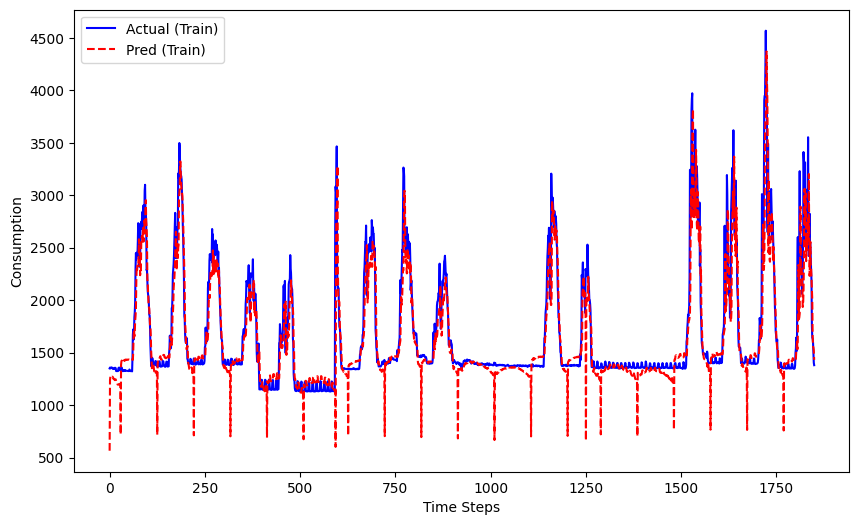

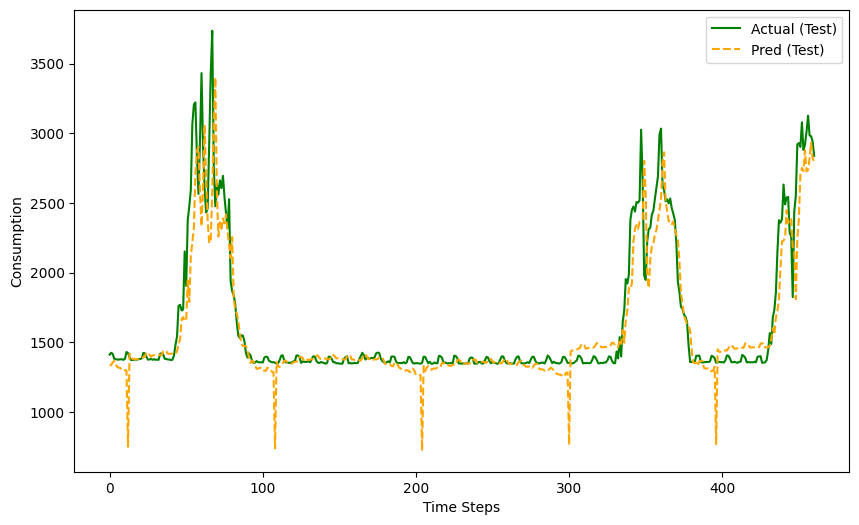

In [14]:
import matplotlib.pyplot as plt

# Plot predictions vs actual
plt.figure(figsize=(10, 6))
plt.plot(y_train_inv, label='Actual (Train)', color='blue')
plt.plot(y_train_pred, label='Pred (Train)', linestyle='dashed', color='red')

plt.xlabel('Time Steps')
plt.ylabel('Consumption')
plt.legend()
plt.show()

# Plot predictions vs actual
plt.figure(figsize=(10, 6))

plt.plot(y_test_inv, label='Actual (Test)', color='green')
plt.plot(y_test_pred, label='Pred (Test)', linestyle='dashed', color='orange')

plt.xlabel('Time Steps')
plt.ylabel('Consumption')
plt.legend()
plt.show()


## Run modelwith saved weights
Get Data

In [15]:
import pandas as pd
from database.BuildingRepository import BuildingRepository
from datetime import datetime, timedelta

building_repo = BuildingRepository()
df_test = pd.DataFrame(building_repo.get_power_historic(datetime.now()-timedelta(hours=24)))
df_test = df_test.drop("_id", axis=1)

df_test['datetime'] = pd.to_datetime(df_test['datetime'])
# Calculate the datetime for 24 hours ago from the current time
current_time = df_test['datetime'].max()
twenty_four_hours_ago = current_time - timedelta(hours=24)

# Filter the DataFrame to get only the rows for the last 24 hours
last_24_hours_data = df_test[df_test['datetime'] >= twenty_four_hours_ago]

last_24_hours_data['totalpower'] = pd.to_numeric(last_24_hours_data['totalpower'], errors='coerce')
last_24_hours_data['Month'] = last_24_hours_data['datetime'].dt.month
last_24_hours_data['Day'] = last_24_hours_data['datetime'].dt.day
last_24_hours_data['Hour'] = last_24_hours_data['datetime'].dt.hour
last_24_hours_data['Minute'] = last_24_hours_data['datetime'].dt.minute

last_24_hours_data.rename(columns={'totalpower': 'Consumption'}, inplace=True)

last_24_hours_data['datetime'] = pd.to_datetime(last_24_hours_data['datetime'], format='%Y-%m-%d %H:%M:%S', dayfirst=True)
last_24_hours_data.set_index("datetime", inplace=True)
last_24_hours_data = last_24_hours_data.resample('15T').mean()

last_24_hours_data.drop(['totalgeneration'], axis=1, inplace=True)

last_24_hours_data = last_24_hours_data.dropna()
last_24_hours_data['Consumption-1'] = last_24_hours_data['Consumption'].shift(1)
last_24_hours_data.loc[last_24_hours_data['Day'] != last_24_hours_data['Day'].shift(1), 'Consumption-1'] = 0
last_24_hours_data['Consumption-2'] = last_24_hours_data['Consumption'].shift(2)
last_24_hours_data.loc[last_24_hours_data['Day'] != last_24_hours_data['Day'].shift(2), 'Consumption-2'] = 0
#last_24_hours_data = last_24_hours_data[['Month', 'Day', 'Hour', 'Consumption-1', 'Consumption-2', 'Consumption']]
last_24_hours_data = last_24_hours_data[['Month', 'Day', 'Hour', 'Minute', 'Consumption-1', 'Consumption-2', 'Consumption']]
last_24_hours_data

,Month,Day,Hour,Minute,Consumption-1,Consumption-2,Consumption
datetime,,,,,,,
2023-11-13 16:45:00,11.0,13.0,16.0,55.518325,0.000000,0.000000,2552.689687
2023-11-13 17:00:00,11.0,13.0,17.0,7.000000,2552.689687,0.000000,2462.121848
2023-11-13 17:15:00,11.0,13.0,17.0,22.000000,2462.121848,2552.689687,2423.559444
2023-11-13 17:30:00,11.0,13.0,17.0,37.000000,2423.559444,2462.121848,2377.870556
2023-11-13 17:45:00,11.0,13.0,17.0,52.000000,2377.870556,2423.559444,2216.674444
...,...,...,...,...,...,...,...
2023-11-14 15:45:00,11.0,14.0,15.0,52.000000,2984.654441,3126.559991,2979.488881
2023-11-14 16:00:00,11.0,14.0,16.0,6.805970,2979.488881,2984.654441,2941.008447
2023-11-14 16:15:00,11.0,14.0,16.0,22.000000,2941.008447,2979.488881,2838.018886


Load model

In [16]:
import joblib

# Load the scaler
scaler_test = joblib.load('training_1/scaler.pkl')
pred_scaler_test = joblib.load('training_1/pred_scaler.pkl')

df_scaled = scaler_test.fit_transform(last_24_hours_data)

print("Len pred", int(len(df_scaled)))

Len pred 97


In [17]:
import numpy as np
timesteps = 1

def prepare_data(data, time_steps):
    X, y = [], []
    for i in range(len(data) - time_steps - 2):
        X.append(data[i:i + time_steps, :-1])  # Exclude the last column (Consumption)
        y.append(data[i + time_steps, -1])  # The last column (Consumption) is the target
    return np.array(X), np.array(y)

X_pred, y = prepare_data(df_scaled, timesteps)

print("X_pred shape", X_pred.shape, "timesteps", timesteps)

# reshape input to be [samples, time steps, features]
X_pred = np.reshape(X_pred, (X_pred.shape[0], timesteps, X_pred.shape[2]))

print("X_pred shape", X_pred.shape, "y_pred shape", y.shape)

X_pred shape (94, 1, 6) timesteps 1
X_pred shape (94, 1, 6) y_pred shape (94,)


### load model

In [18]:
import tensorflow as tf

model = tf.keras.models.load_model('saved_model/consumption_forecast')
y_pred = model.predict(X_pred)
y_pred = pred_scaler_test.inverse_transform(y_pred)
y = pred_scaler_test.inverse_transform(y.reshape(-1, 1))

3/3 [==============================] - 0s 3ms/step


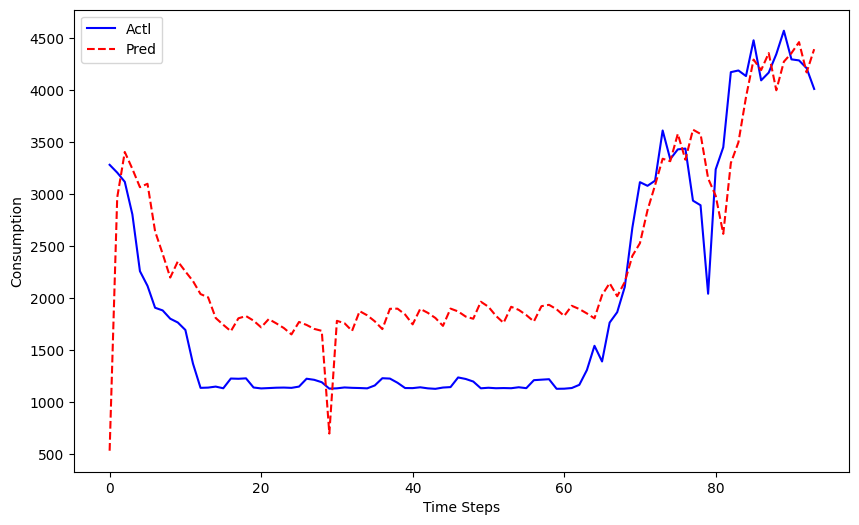

In [19]:
import matplotlib.pyplot as plt

# Plot predictions vs actual
plt.figure(figsize=(10, 6))
plt.plot(y, label='Actual', color='blue')
plt.plot(y_pred, label='Pred', linestyle='dashed', color='red')

plt.xlabel('Time Steps')
plt.ylabel('Consumption')
plt.legend()
plt.show()


In [20]:
last = scaler_test.inverse_transform(df_scaled[:-3])

df = pd.DataFrame(last, columns=['Month', 'Day', 'Hour', 'Minute', 'Consumption-1', 'Consumption-2', 'Consumption'])
df['Prediction'] = y_pred
df['datetime'] = pd.to_datetime(df[['Month', 'Day', 'Hour', 'Minute']].assign(Year=2023))

# Drop the separate columns if needed
df.drop(['Month', 'Day', 'Hour', 'Minute'], axis=1, inplace=True)

df.set_index("datetime", inplace=True)
df = df.resample('1H').mean()
df["datetime"] = df.index
# Now, 'datetime' contains the combined datetime values
df

,Consumption-1,Consumption-2,Consumption,Prediction,datetime
datetime,,,,,
2023-11-13 16:00:00,0.000000,0.000000,2552.689687,535.934204,2023-11-13 16:00:00
2023-11-13 17:00:00,2454.060384,1859.592745,2370.056573,3169.500488,2023-11-13 17:00:00
2023-11-13 18:00:00,1941.929179,2097.957929,1822.903623,2591.415283,2023-11-13 18:00:00
2023-11-13 19:00:00,1691.100000,1718.643056,1625.275694,2203.653320,2023-11-13 19:00:00
2023-11-13 20:00:00,1388.809722,1458.942361,1358.180556,1811.792969,2023-11-13 20:00:00
2023-11-13 21:00:00,1390.882639,1380.660417,1391.840972,1785.210693,2023-11-13 21:00:00
2023-11-13 22:00:00,1356.494444,1368.085417,1356.404861,1731.028320,2023-11-13 22:00:00
2023-11-13 23:00:00,1370.047917,1358.920833,1379.663889,1727.007568,2023-11-13 23:00:00
2023-11-14 00:00:00,1023.059028,684.431944,1362.761111,1482.540161,2023-11-14 00:00:00
